In [174]:
import numpy as np
import sounddevice as sd
import datetime
from scipy.signal import butter, lfilter
from scipy.io import wavfile

def generate_white_noise(duration, sample_rate):
    """
    generate white noise
    to make experiments reproducible, set a seed
    """
    np.random.seed(42)
    white_noise = np.random.randn(int(sample_rate * duration))
    return white_noise

def band_limited_white_noise(low, high, duration, sample_rate):
    """Apply a butterworth filter"""
    white_noise = generate_white_noise(duration, sample_rate)
    nyq = 0.5 * sample_rate
    low = low / nyq
    high = high / nyq
    b, a = butter(5, [low, high], btype='band')
    band_limited = lfilter(b, a, white_noise)
    return band_limited

def pseudo_white_noise(low, high, repetitions, duration, sample_rate):
    """Generate pseudoNoise"""
    # use sinusoidal signal with random phase as pseudo noise
    # t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    # pseudo_noise = np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2 * np.pi))
    band_limited_noise = band_limited_white_noise(low, high, duration/repetitions)
    pseudo_noise = np.tile(band_limited_noise, repetitions)
    # store the sound signal
    # Format the date and time
    filename = f"pseudoNoise_{low}_{high}.wav"
    wavfile.write(filename, sample_rate, pseudo_noise)
    return pseudo_noise

import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


In [176]:

# select the file
from bf3d_prep import bf3d_data_prep
import numpy as np

eq_prep = bf3d_data_prep(rootfolder = 'Recordings/HATS_recordings', filetype = '.npz')


Dropdown(description='Select:', options=('..', 'equalizer_HP1.npz'), value='..')

Button(description='Select', style=ButtonStyle())

Output()

In [177]:
# read the .npz file
# load the filter and the reference level
equalizer = np.load('Recordings/HATS_recordings/equalizer_HP1.npz')
filter_rec = equalizer['filter']
ref_level = equalizer['ref_level']
sample_rate = equalizer['sample_rate']

In [179]:
sample_rate

array(32768)

In [180]:

# generate and play white noise
# for i in np.arange(10):
duration = 30 # 10s
band_limited_noise = band_limited_white_noise(20, 12000, duration, sample_rate)

# apply the filte
# eq_noise = eq_prep.apply_eq(band_limited_noise, fs = 44100, filter_rec, ref_level)


In [183]:
# channel 0: left ear, channel 1: right ear 
play_sound(sound = band_limited_noise, channel=0, sample_rate = sample_rate)

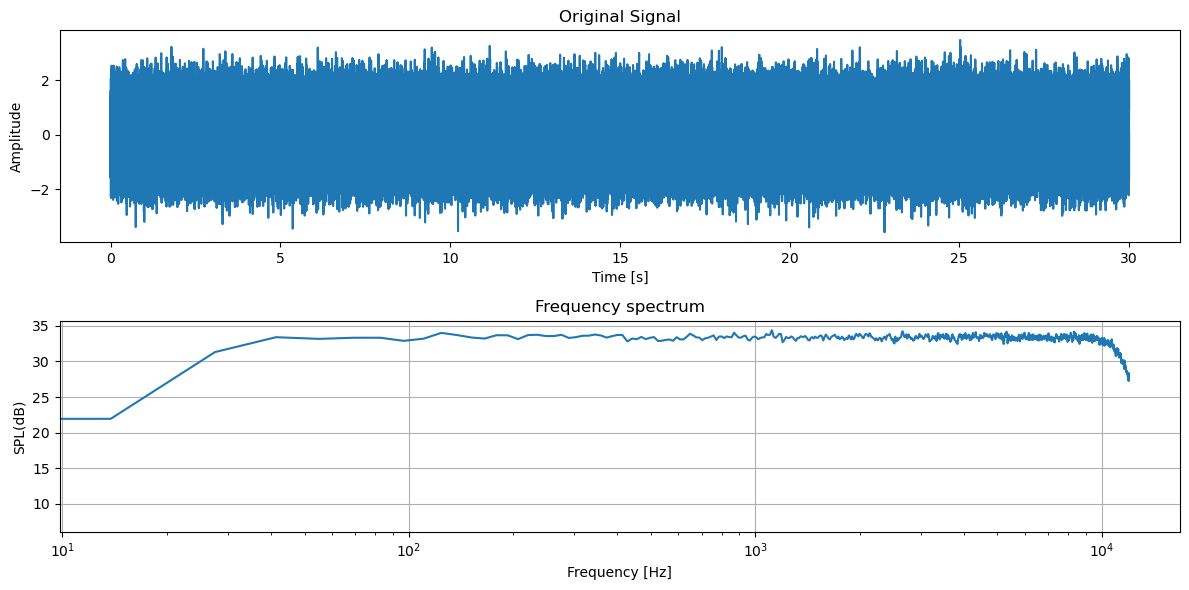

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# parameters：
time_signal = np.arange(0, duration, 1/sample_rate)
data_signal = band_limited_noise

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=3200, return_onesided=True)

# choose the frequency range of fft analysis
min_freq = 0
max_freq = 12000
mask = (frequencies >= min_freq) & (frequencies <= max_freq)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, data_signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.semilogx(frequencies[mask],20*np.log10(np.abs(fft_result[mask])/20e-6))
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
plt.show()


In [136]:
# from this block is for the HATs recording
# it will import the .wav file

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.io import wavfile

# select the file
from bf3d_prep import bf3d_data_prep
import numpy as np

recording_prep = bf3d_data_prep(rootfolder = 'Recordings/HATS_recordings', filetype = '.wav')


Dropdown(description='Select:', options=('..', 'HP1-12.8kHz-leftear.wav', 'HP1-eqed-leftear-fir.wav', 'HP1-eqe…

Button(description='Select', style=ButtonStyle())

Output()

In [7]:
# calculate the db spl for specific pa
pa = 10
db_spl = 20 * np.log10(pa / 20e-6)
print(f"The sound pressure level for {pa} Pa is {db_spl} dB SPL")

The sound pressure level for 10 Pa is 113.97940008672037 dB SPL


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_23236\2134951247.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, hats_t = wavfile.read(recording_prep.selected_file)


The peak value is 86.47196146222406 dB SPL


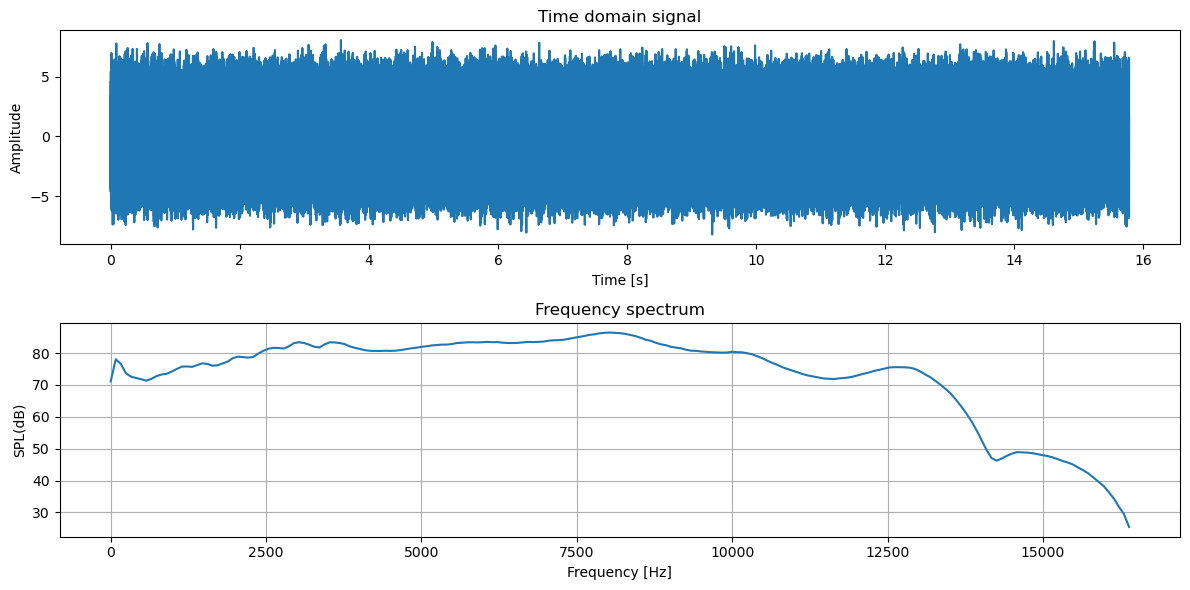

In [137]:
# read the wav file
# get the frequency response by welch method
# 94 dB re 20uPa

sample_rate, hats_t = wavfile.read(recording_prep.selected_file)

#sample_rate = 44100
# hats_t = sin_signal
# the raw wav datas should be converted to pa
# the factor 32767 is the maximum value of the 16-bit integer
# hats_t = hats_t / (2**32/2-1)* 10

time_signal = np.arange(0, len(hats_t)/sample_rate, 1/sample_rate)
data_signal = hats_t / (2**32/2-1)* 10

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=400, return_onesided=True)

# The fft_result is the rms
# fft_result = np.sqrt(2) * fft_result
fft_result = np.sqrt( fft_result )

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, data_signal)
plt.title('Time domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


plt.subplot(2, 1, 2)
plt.plot(frequencies,20*np.log10(np.abs(fft_result)/20e-6))
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
# get the peak value
peak_value = np.max(20*np.log10(np.abs(fft_result)/20e-6))
print(f"The peak value is {peak_value} dB SPL")
plt.show()



In [168]:
ref_level

0.0022182868385177443

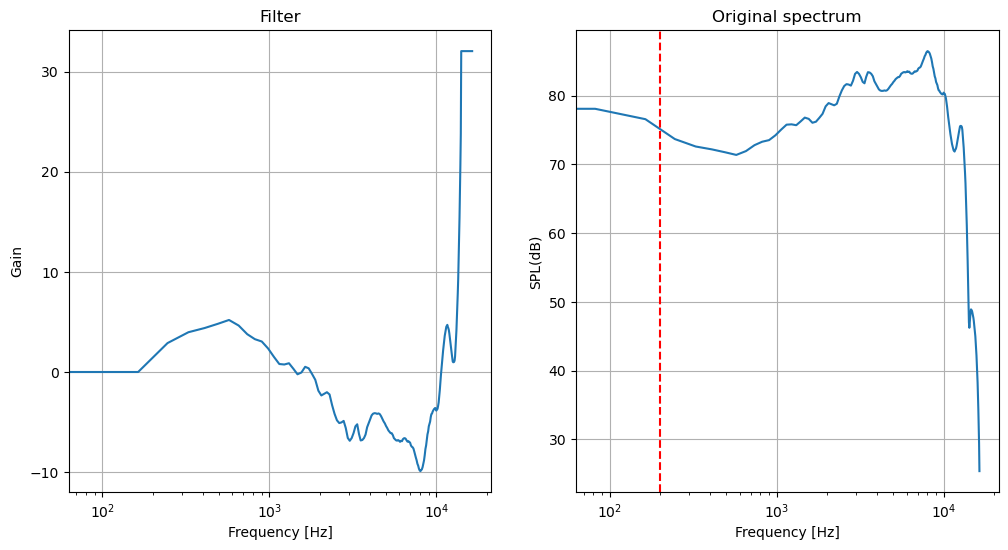

the lowest gain is -9.897837663706037 dB


In [150]:
# based on the spectrum I get, revert it, then get a filter
# the filter is used to filter the original signal

# select the low frequency, set it as a reference
low_freq = 200

# select the high frequency, set all the values above it to be 10
# the original stimulus upper limit is 12000 Hz
# high_freq = 10000

# get the index of the low frequency
low_freq_index = np.argmin(np.abs(frequencies - low_freq))
# get the index of the high frequency
# high_freq_index = np.where(frequencies >= high_freq)[0][0]

# set a reference level, to make different equipment comparable
# all equipment should have the same reference level
ref_level = fft_result[low_freq_index]

# scale the fft_result, where the low frequency is the reference, should be 0 dB
fft_result_rec = fft_result / ref_level

# make all the values below the low frequency to be 1
fft_result_rec[:low_freq_index] = 1

# revert the fft_result
fft_result_rec = 1/(fft_result_rec)

fft_result_rec[fft_result_rec > 20] = 40

# set a upper limit for the entire frequency range
# fft_result_rec[high_freq_index:] = 10


# get the filter
filter_rec = np.real(fft_result_rec)

# plot the filter
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(frequencies, 20*np.log10(filter_rec))
plt.title('Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.subplot(1, 2, 2)
plt.semilogx(frequencies, 20*np.log10(np.abs(fft_result)/20e-6))
# draw a line at the low frequency
plt.axvline(x=low_freq, color='r', linestyle='--')
plt.title('Original spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.grid()

plt.show()

print(f"the lowest gain is {np.min(20*np.log10(filter_rec))} dB")

In [120]:
sample_rate

32768

In [167]:
from scipy.signal import firwin2, freqz, minimum_phase

fs = sample_rate

# make sure frequncies stoped with fs/2
fq = np.concatenate((frequencies, [fs/2]))
fr = np.concatenate((filter_rec, [filter_rec[-1]]))

fir_filt = firwin2(1023, frequencies, filter_rec, fs = fs, antisymmetric=False)

fir_filt = minimum_phase(fir_filt)

In [54]:
np.log10(20e-6)

-4.698970004336019

<Figure size 1200x600 with 0 Axes>

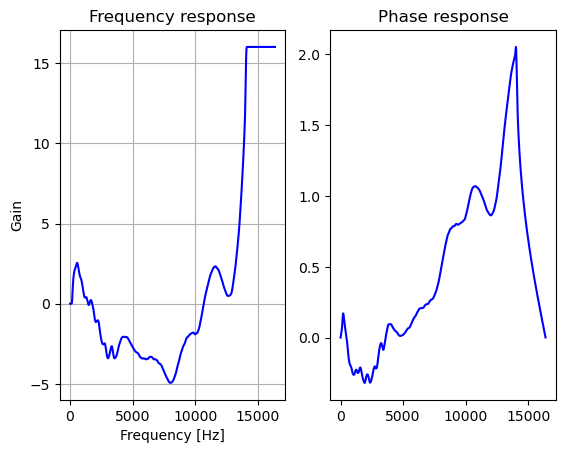

the lowest gain is -4.941170797045054 dB


In [168]:

import matplotlib.pyplot as plt


def my_plot(w, h):
    plt.figure()
    plt.subplot(121)
    plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), 'b')
    plt.title("Frequency response")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()
    plt.subplot(122)
    # plot the angle response
    plt.plot(0.5*fs*w/np.pi, np.angle(h), 'b')
    plt.title("Phase response")
    plt.show()  

p = plt.figure(figsize=(12, 6))

w, h = freqz(fir_filt, worN=8000, plot=my_plot)
print(f"the lowest gain is {np.min(20*np.log10(np.abs(h)))} dB")

the length of the convolved data is 517506


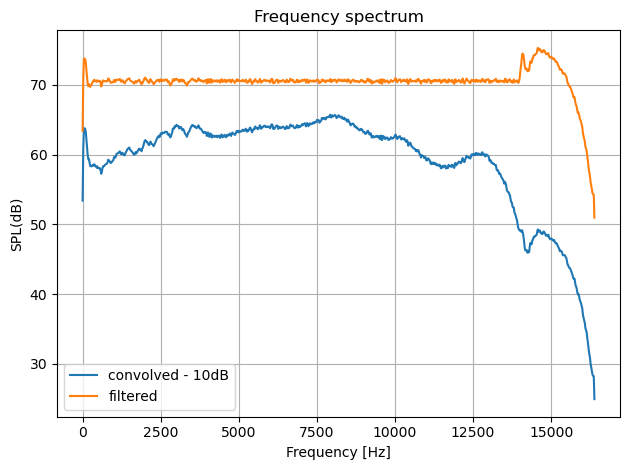

In [169]:
conv_data = np.convolve(data_signal, fir_filt, mode="full")

filt_data = filtfilt(fir_filt, 1, data_signal)
print(f"the length of the convolved data is {len(conv_data)}")

# FFT
conv_freq, conv_fft = welch(conv_data, fs=sample_rate, scaling='spectrum', nperseg=1600, return_onesided=True)
filt_freq, filt_fft = welch(filt_data, fs=sample_rate, scaling='spectrum', nperseg=1600, return_onesided=True)

# The fft_result is the rms
# fft_result = np.sqrt(2) * fft_result
conv_fft = np.sqrt(conv_fft)
filt_fft = np.sqrt(filt_fft)

plt.plot(conv_freq,20*np.log10(np.abs(conv_fft)/20e-6)-10, label = 'convolved - 10dB')
plt.plot(filt_freq,20*np.log10(np.abs(filt_fft)/20e-6), label = 'filtered')
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.legend()
plt.tight_layout()
plt.grid()

In [170]:
filt_noise = filtfilt(fir_filt, 1, band_limited_noise)
conv_noise = np.convolve(band_limited_noise, fir_filt, mode="full")


In [109]:
play_sound(sound=band_limited_noise, channel=0, sample_rate=sample_rate)

In [172]:
play_sound(sound = filt_noise, channel=0, sample_rate=sample_rate)

In [31]:
# save the equalizer, and the reference level into a file
# the file is used to equalize the original signal
# for different equipment, the reference level will be taken to make a same level output

# save the filter_rec and the reference level
np.savez(f'Recordings/HATS_recordings/equalizer_HP1.npz', 
         filter=fir_filt, 
         ref_level=ref_level, 
         frequency=frequencies, 
         sample_rate=sample_rate)


In [11]:


# save the filter as a .wav file
# the filter is the inverse of the spectrum
# the filter is used to filter the original signal
# the filter is used to make the original signal to be flat

from scipy.signal import firwin, lfilter
from scipy.io import wavfile

filter = np.abs(fft_result_rec)


In [20]:
# apply the filter to the white noise
# the filter is the fft_result_rec

# get the time domain signal
time_signal = np.arange(0, duration, 1/sample_rate)
# get the original white noise
white_noise = band_limited_white_noise(20, 16000, duration)

# interpolate the fft_result_rec to make it match the length of the white noise
fft_result_rec = np.interp(np.arange(len(white_noise)), np.arange(len(fft_result_rec)), fft_result_rec)

# get the filtered white noise
filtered_white_noise = np.fft.irfft(np.fft.rfft(white_noise) * fft_result_rec)

# play the filtered white noise
play_sound(sound = filtered_white_noise, channel=0)

# plot the time domain signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, white_noise)
plt.title('Original white noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time_signal, filtered_white_noise)
plt.title('Filtered white noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (661501,) (1323000,) 